# Projeto 2 - NLP

-----

O segundo projeto do módulo de Machine Learning será focado no processamento de linguagem natural! Usaremos os algoritmos aprendidos e as técnicas vistas na segunda parte do curso para extrairmos informações relevantes de texto. Mais precisamente, de publicações no Twitter.

## Os Dados

Utilizaremos um Dataset obtido do Twitter com 100K postagens entre os dias 01/08/2018 e 20/10/2018. Cada postagem é classificada como **positiva**, **negativa** ou **neutra**.  

Dois arquivos serão disponilizados para o desenvolvimento dos modelos, um para treino/validação e outro para submissão. Os arquivos se encontram na pasta */Dados/train* e */Dados/subm*, respectivamente.

Descrição das colunas:

- **id**: ID único para o tweet  
- **tweet_text**: Texto da publicação no Twitter  
- **tweet_date**: Data da publicação no Twitter  
- **sentiment**: 0, se negativo; 1, se positivo; 2, se neutro  
- **query_used**: Filtro utilizado para buscar a publicação

## O Problema

Você deverá desenvolver um modelo para detectar o sentimento de uma publicação do Twitter a classificando em uma das três categorias: **positiva**, **negativa** ou **neutra**. O texto da publicação está disponível na coluna "tweet_text". Teste pelo menos 3 técnicas de NLP diferentes e escolha a métrica de avaliação que julgar mais pertinente.  

Escolha o melhor modelo e gere uma base a partir dos dados de submissão, que estão no caminho ```Dados/subm/Subm3Classes.csv```, com o seguinte formato:


|id|sentiment_predict
|-|-|
|12123232|0
|323212|1
|342235|2

Salve essa tabela como um arquivo csv com o nome ```<nome>_<sobrenome>_nlp_degree.csv``` e submeta-o como parte da entrega final do projeto.  

Para ajudar no desenvolvimento, é possível dividir o projeto em algumas fases:

- **Análise de consistência dos dados**: analise se os dados estão fazendo sentido, se os campos estão completos e se há dados duplicados ou faltantes. Se julgar necessário, trate-os.    


- **Análise exploratória**: analise a sua base como um todo, verifique o balanceamento entre as classes e foque, principalmente, na coluna ```tweet_text```.    


- **Pré-processamento e transformações**: projetos de NLP exigem um considerável pré-processamento. Foque no tratamento da string do texto. Procure começar com tratamentos simples e adicione complexidade gradualmente. Nessa etapa você testará diferentes técnicas de transformações, como o Bag Of Words e o TF-IDF.    


- **Treinamento do modelo**: depois das transformações, você poderá executar o treinamento do modelo classificador. Nessa etapa o problema se torna semelhante aos abordados na primeira parte do módulo. Você pode testar diversos classificadores como RandomForest, AdaBoost, entre outros. Otimize os hiperparâmetros do modelo com técnicas como a GridSearch e a RandomizedSearch.    


- **Conclusões**: descreva, em texto, as conclusões sobre os seus estudos. O modelo é capaz de identificar o sentimento das publicações? É possível extrapolar o modelo para outros contextos, como a análise de sentimento de uma frase qualquer? Pense em questões pertinentes e relevantes que você tenha obtido durante o desenvolvimento do projeto!     



## Critérios de avaliação

Os seguintes itens serão avaliados:

1. Desenvolvimento das etapas descritas acima;


2. Reprodutibilidade do código: seu código será executado e precisa gerar os mesmos resultados apresentados por você;


3. Clareza: seu código precisa ser claro e deve existir uma linha de raciocínio direta. Comente o código em pontos que julgar necessário para o entendimento total;


4. Justificativa das conclusões obitdas: não existirá certo ou errado, mas as decisões e as conclusões precisam ser bem justificadas com base nos resultados obtidos.  

O desempenho do modelo **não** será considerado como critério de avaliação.  

## Dicas

### Base de treino e submissão

A base de submissão não possui a variável de saída, portanto ela será utilizada **apenas** para gerar o arquivo que acompanha a submissão do projeto.      

### Tente encontrar possíveis vieses

É muito comum que modelos de NLP possuam fortes vieses, como a tendência de relacionar palavras específicas com alguma classe de saída. Tente encontrar vieses no seu estudo, isso pode ajudar a tirar boas conclusões. o campo "query_used" pode ser útil para essa análise.  

### O pré-processamento é a chave para um bom desempenho

Essa é a etapa que mais vai contribuir para o desempenho do seu modelo. Seja criativo e desenvolva essa etapa de uma maneira que seja fácil de aplicar o mesmo processamento para uma nova base, você terá que fazer isso para gerar a base de submissão.

### Um termômetro para o seu desenvolvimento

Após a correção do seu projeto, o professor irá disponibilizar a sua acurácia obtida na base de submissão. Você pode interpretar esse resultado como a simulação do resultado do seu modelo em produção. Uma diferença entre o resultado do estudo e o resultado de submissão indica um grau de **overfitting** no seu modelo.

-------

# Desenvolvimento do projeto

In [1]:
# Importando as bibliotecas necessárias
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, mean_absolute_error
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler

from mlxtend.plotting import plot_confusion_matrix

from lightgbm import LGBMClassifier

import missingno as msno
from wordcloud import WordCloud, STOPWORDS
from gensim.utils import simple_preprocess
from gensim.models import Word2Vec
from tqdm import tqdm

import nltk # natural language tool kit
nltk.download('rslp')
from nltk.stem import RSLPStemmer
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package rslp to
[nltk_data]     C:\Users\thacr\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping stemmers\rslp.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\thacr\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

## 1. Divisão da base de teste

In [2]:
df = pd.read_csv('Dados/train/Train3Classes.csv')

print(df.shape)

df.sample(10).head()

(95000, 5)


,id,tweet_text,tweet_date,sentiment,query_used
2997,1045397433558159361,Nós apanhamos com chuva sem problema... mas as...,Thu Sep 27 19:39:05 +0000 2018,1,:)
22222,1040020746037288960,Supremo considera ilegal a opção pelo ensino d...,Wed Sep 12 23:34:03 +0000 2018,2,folha
38759,1044996567311233026,"Pesquisa Ibope para presidente: Bolsonaro, 27%...",Wed Sep 26 17:06:11 +0000 2018,2,g1
83225,1042979604602863616,O ser humano começa flertando de brincadeira q...,Fri Sep 21 03:31:30 +0000 2018,2,#fato
37546,1045350658898120704,Nesse ano estrei como Coordenador na trilha de...,Thu Sep 27 16:33:13 +0000 2018,1,:)


In [3]:
df.head()

,id,tweet_text,tweet_date,sentiment,query_used
0,1049721159292346368,Rio elege maior bancada policial de sua histór...,Tue Oct 09 18:00:01 +0000 2018,2,folha
1,1046251157025423360,fiquei tão triste quando eu vi o preço da câme...,Sun Sep 30 04:11:28 +0000 2018,0,:(
2,1041744620206653440,"Para Theresa May, seu plano para o Brexit é a ...",Mon Sep 17 17:44:06 +0000 2018,2,exame
3,1046937084727107589,caralho eu quero proteger a danielly em um pot...,Tue Oct 02 01:37:06 +0000 2018,0,:(
4,1047326854229778432,@SiCaetano_ viva o caos :),Wed Oct 03 03:25:55 +0000 2018,1,:)


Percebe-se que o DF não está ordenado pela data

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95000 entries, 0 to 94999
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          95000 non-null  int64 
 1   tweet_text  95000 non-null  object
 2   tweet_date  95000 non-null  object
 3   sentiment   95000 non-null  int64 
 4   query_used  95000 non-null  object
dtypes: int64(2), object(3)
memory usage: 3.6+ MB


In [5]:
# Hold out (separando 10% do DF para teste)
df_train, df_test = train_test_split(df, test_size=0.1, random_state=2022)

In [6]:
print(df_test.shape)

df_test.sample(10).head()

(9500, 5)


,id,tweet_text,tweet_date,sentiment,query_used
55007,1049140132559896576,@JesusMeMorre não morre não :( https://t.co/Oj...,Mon Oct 08 03:31:14 +0000 2018,0,:(
39523,1050343587282595840,Ciclone atinge a costa leste da Índia com vent...,Thu Oct 11 11:13:20 +0000 2018,2,g1
41890,1037610201946513409,#FLA #Fato “Eu voto em Jair Bolsonaro” - https...,Thu Sep 06 07:55:24 +0000 2018,2,#fato
19442,1049187517533233152,@_weli__ @Danielly_Jesus @vickivashkov Tem raz...,Mon Oct 08 06:39:31 +0000 2018,1,:)
31503,1045466182168367106,"tudo que eu tava db hoje, fiquei puto :)",Fri Sep 28 00:12:16 +0000 2018,1,:)


In [7]:
print(df_train.shape)

df_train.sample(10).head()

(85500, 5)


,id,tweet_text,tweet_date,sentiment,query_used
66934,1046929303466909696,eu quero uma camisa rosa :(,Tue Oct 02 01:06:11 +0000 2018,0,:(
12326,1043672613623685120,"""Tinha o rosto e o corpo um pouco magros, cabe...",Sun Sep 23 01:25:16 +0000 2018,2,#trabalho
26208,1046233365769326592,@pleasesabino Ai menina :( próxima vez a gente...,Sun Sep 30 03:00:47 +0000 2018,0,:(
70842,1049204493630537728,@tereutrettel Qria mrm :( aquele aviao e bota ...,Mon Oct 08 07:46:59 +0000 2018,0,:(
48784,1046714488551092224,@bolinhoofc mas vc eh mais :(,Mon Oct 01 10:52:35 +0000 2018,0,:(


## 2. Análise de consistência dos dados

<AxesSubplot:>

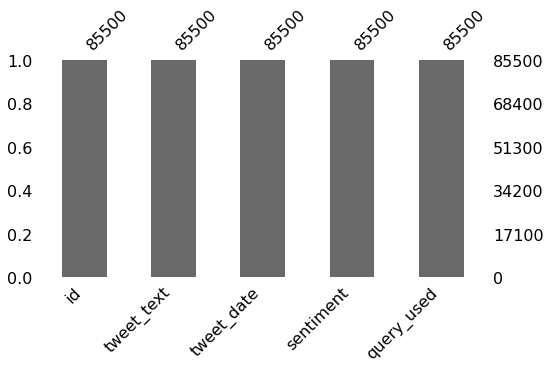

In [8]:
# Visualizando a porcentagem de dados válidos
msno.bar(df_train, figsize=(8, 4))

<AxesSubplot:>

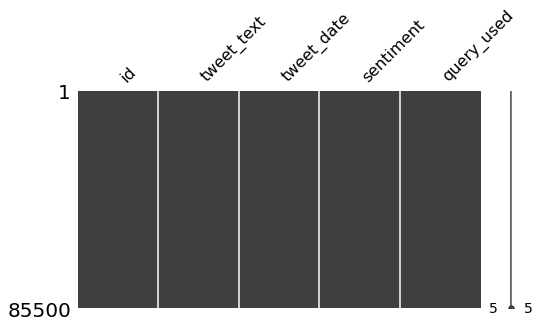

In [9]:
# Verificando se há dados nulos
msno.matrix(df_train, figsize=(8, 4))

Não há dados faltantes.

In [10]:
# Verificando dados duplicados no DF original inteiro
df[df.duplicated()].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          0 non-null      int64 
 1   tweet_text  0 non-null      object
 2   tweet_date  0 non-null      object
 3   sentiment   0 non-null      int64 
 4   query_used  0 non-null      object
dtypes: int64(2), object(3)
memory usage: 0.0+ bytes


In [11]:
# Verificando dados duplicados em "tweet_text", no DF original
df[df['tweet_text'].duplicated()].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 816 entries, 1088 to 94760
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          816 non-null    int64 
 1   tweet_text  816 non-null    object
 2   tweet_date  816 non-null    object
 3   sentiment   816 non-null    int64 
 4   query_used  816 non-null    object
dtypes: int64(2), object(3)
memory usage: 38.2+ KB


In [12]:
print('DF original')
print(f'Porcentagem de duplicatas em "tweet_text": {((df.tweet_text.duplicated().sum())/(df.shape[0]))*100:.2f}%')

DF original
Porcentagem de duplicatas em "tweet_text": 0.86%


In [13]:
# Verificando dados duplicados em "tweet_text", no DF de treino
df_train[df_train['tweet_text'].duplicated()].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 682 entries, 36965 to 54077
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          682 non-null    int64 
 1   tweet_text  682 non-null    object
 2   tweet_date  682 non-null    object
 3   sentiment   682 non-null    int64 
 4   query_used  682 non-null    object
dtypes: int64(2), object(3)
memory usage: 32.0+ KB


In [14]:
print('DF de treino')
print(f'Porcentagem de duplicatas em "tweet_text": {((df_train.tweet_text.duplicated().sum())/(df_train.shape[0]))*100:.2f}%')

DF de treino
Porcentagem de duplicatas em "tweet_text": 0.80%


Não há dados duplicados em relação do DF como um todo. E como há menos de 1% de duplicatas em "tweet_text", isso não deve impactar na análise exploratória e/ou performance do(s) modelos(s). Portanto, vamos manter o DF como está, sem remover essas duplicatas.

## 3. Análise exploratória

### 3.1 Target

In [15]:
# Verificando a porcentagem dos valores do target no DF original
np.round(df['sentiment'].value_counts(normalize=True)*100, 2)

0    33.36
1    33.35
2    33.29
Name: sentiment, dtype: float64

Os dados estão balanceados.

Vamos verificar se esse balanceamento se mantém, após ter separado uma parte do DF para teste.

In [16]:
# Verificando a porcentagem dos valores do target no DF de teste
np.round(df_test['sentiment'].value_counts(normalize=True)*100, 2)

0    33.61
1    33.28
2    33.11
Name: sentiment, dtype: float64

In [17]:
# Verificando a porcentagem dos valores de target no DF de treino
np.round(df_train['sentiment'].value_counts(normalize=True)*100, 2)

1    33.35
0    33.34
2    33.31
Name: sentiment, dtype: float64

### 3.2 Coluna "query_used"

In [18]:
# Verificando a porcentagem dos valores de "query_used" no DF de treino
np.round(df_train['query_used'].value_counts(normalize=True)*100, 2)

:)               33.35
:(               33.34
folha             5.25
estadao           4.11
#fato             3.63
g1                3.62
exame             3.60
#trabalho         3.19
#oportunidade     2.60
jornaloglobo      2.50
veja              2.24
#noticia          1.18
#novidade         0.97
#curiosidade      0.41
Name: query_used, dtype: float64

In [19]:
df_train[(df_train['sentiment'] == 0)]['query_used'].value_counts()

:(    28503
Name: query_used, dtype: int64

In [20]:
df_train[(df_train['sentiment'] == 1)]['query_used'].value_counts()

:)    28516
Name: query_used, dtype: int64

In [21]:
df_train[(df_train['sentiment'] == 2)]['query_used'].value_counts()

folha            4490
estadao          3516
#fato            3104
g1               3093
exame            3080
#trabalho        2728
#oportunidade    2227
jornaloglobo     2135
veja             1917
#noticia         1010
#novidade         828
#curiosidade      353
Name: query_used, dtype: int64

Percebe-se que a coluna "query_used" já ajudaria a prever o sentimento dos textos. Porém, a proposta é focar em "tweet_text".

### 3.3 Datas

In [22]:
# Verificando a data inicial, sem tranformar a feature de objeto para data
df_train['tweet_date'].min()

'Fri Aug 17 14:50:33 +0000 2018'

In [23]:
# Verificando a data final, sem tranformar a feature de objeto para data
df_train['tweet_date'].max()

'Wed Sep 26 23:58:10 +0000 2018'

In [24]:
# Transformando "tweet_date" de objeto para data
df_train = df_train.copy()
df_train['tweet_date'] = pd.to_datetime(df_train['tweet_date'])

In [25]:
# Verificando se o tipo foi alterado em "tweet_date"
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 85500 entries, 43311 to 86909
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype              
---  ------      --------------  -----              
 0   id          85500 non-null  int64              
 1   tweet_text  85500 non-null  object             
 2   tweet_date  85500 non-null  datetime64[ns, UTC]
 3   sentiment   85500 non-null  int64              
 4   query_used  85500 non-null  object             
dtypes: datetime64[ns, UTC](1), int64(2), object(2)
memory usage: 3.9+ MB


In [26]:
df_train['tweet_date'].min()

Timestamp('2018-08-09 01:59:00+0000', tz='UTC')

In [27]:
df_train['tweet_date'].max()

Timestamp('2018-10-19 18:40:47+0000', tz='UTC')

Sem transformar "tweet_date" de objeto para "datetime", a data inicial e final não correspondem às verdadeiras, devido ao dia da semana aparecer no início de cada data.

### 3.4 Duplicados

In [28]:
# Verificando 10 exemplos de textos únicos, dentre os duplicados
pd.DataFrame(df_train[df_train['tweet_text'].duplicated()]['tweet_text'].unique()).sample(10)

,0
136,foo :-) : cae81f58-2a01-423e-9fe3-b5e448f4adc0
306,foo :) : ba5340cf-e42c-48df-a9a6-5fc7798a9ecc
101,bar :( : 3a453bdb-ba65-48f5-b71a-bca241e4ac7a
212,bar :( : aee4b824-e16b-4173-abaa-24bfe354662b
178,foo :) : e62d5e14-8529-4c66-b67a-8b24c625aaeb
356,"tenho um blog sobre a vida, o universo e tudo ..."
50,"Analista de Marketing - Belo Horizonte, MG htt..."
418,"Dólar caiu :) - R$3,99 às 12:40"
252,"Açougueiro - São Bernardo do Campo, SP https:/..."
325,"Gerente de RH - Catanduva, SP https://t.co/9vL..."


In [29]:
# Mostrar os textos inteiros na coluna
pd.set_option('display.max_colwidth', None)

# Verificando 10 exemplos de textos únicos, dentre os duplicados
pd.DataFrame(df_train[df_train['tweet_text'].duplicated()]['tweet_text'].unique()).sample(10)

,0
49,Eu tô bem triste :(
110,bar :-( : 7a946a2d-1394-499e-b6aa-7bf0f9ada022
310,"Ohayou! Bom dia, amigos. Outra Segunda... :-("
79,foo :-) : 9e715cae-6e19-4700-9e84-245afbabca6f
401,ai gente :(
100,bar :-( : b4308b01-796e-4f43-b4c5-2c8827a683d3
138,foo :-) : 78ac4c09-f7e7-41e7-8b58-85a04e93339c
268,"Auxiliar de Produção (Expedição) - São Bernardo do Campo, SP https://t.co/yZnWyQzkmp #emprego #oportunidade #vaga"
168,bar :( : 31022c95-404c-4a0d-87a6-e29db9ba289b
232,Bom diaa :)


In [30]:
# Verificando o balanceamento do target entre os textos duplicados
df_train[df_train['tweet_text'].duplicated()]['sentiment'].value_counts()

1    326
0    212
2    144
Name: sentiment, dtype: int64

Que bom! A maioria dos textos duplicados ou copiados são de sentimento positivo. =)

### 3.5 Número de caracteres e palavras

In [31]:
# Criando outro DF só para manipular na análise exploratória
df_train_eda = df_train.copy()

# Criando colunas para verificar o número de caracterers e palavras dos textos
df_train_eda['num_caracteres'] = df_train['tweet_text'].str.len()
df_train_eda['num_palavras'] = df_train['tweet_text'].str.split().str.len()

df_train_eda.head()

,id,tweet_text,tweet_date,sentiment,query_used,num_caracteres,num_palavras
43311,1047562047054127107,"meu pai vai votar no cabo Daciolo, disse que é melhor do que jogar o voto dele fora :)",2018-10-03 19:00:29+00:00,1,:),86,19
83346,1049305280616456193,"@kookteamo me perdoa bebê, tem dias que eu não abro o wpp, estou esperando a sensação ruim que eu estou sentindo no peito passar :( não quero ser chata com ninguém, muito menos contigo :(",2018-10-08 14:27:28+00:00,0,:(,187,35
78821,1050771464515985409,"@nolimcr @loveoflesbian @warnermusicmex $245, 2 CDs + 2 DVDs. Saludos :)",2018-10-12 15:33:34+00:00,1,:),72,11
31205,1040684108836417537,#TVEJA https://t.co/I58krGZ7wR,2018-09-14 19:30:01+00:00,2,veja,30,2
63392,1045437815503421441,bem. Águas Flávias :),2018-09-27 22:19:33+00:00,1,:),21,4


In [32]:
# Verificando o tweet que possui o maior número de caracteres
df_train_eda[df_train_eda['num_caracteres']==df_train_eda['num_caracteres'].max()]

,id,tweet_text,tweet_date,sentiment,query_used,num_caracteres,num_palavras
36682,1049296171339067392,@FtimaFaria7 @beatrizheng1 @leilasbsantos @valdirenealvesr @Fatimasilva7 @Marcosdiasdas17 @leny_cacheada @CarraroSilva10 @martasigrist @marlenelotU2 @sforcinijunior @votorioA1 @OLivro_Sagrado @Josfilh35177225 @SPENDportugal @LuisHen93885989 @rodriguesjonjon @GugaDoze @JosePedro1898 @JesusNasLinhas @ggabrie61874346 @perolastewart @LeandroPoiema @azevedovictor10 @atrebore @jovenscomjesus1 @Meninadultablog @EntreDeuseEu @ConfiaiemDeus @relateicitacoes @FrasesCrist1 @RafaelaRozane @_foiporamor @KethellenCr @MarcelloBrayner @ChurchTimes @TomsFonseca @le_meirelles @DatOneGuyPedro @mendeszec @fbruno1959 @Maggie70883807 @Don_Miguez @helderebelo @robertofife @MiguelxBernardo @JoseAdelinoAlm2 @MariaCordeRosa3 @fasgoncalves @BernardoMBlanco Bom dia! :),2018-10-08 13:51:16+00:00,1,:),751,53


De acordo com uma pesquisa rápida no Google, como o Twitter aceita no máximo 280 caracteres, na verdade, o texto acima seria apenas: "Bom dia! :)".

Como os nomes de usuários não teriam relação com os sentimentos dos textos, vamos removê-los.

In [33]:
# Função para remover os nomes de usuários dos tweets
def clean_username(texts):
    return texts.replace(r'@\S+', '', regex=True)

In [34]:
# Removendo os nomes de usuários dos textos
df_train_eda['tweet_text'] = clean_username(df_train_eda['tweet_text'])

In [35]:
# Refazendo as colunas com o número de caracterers e palavras dos textos
df_train_eda['num_caracteres'] = df_train_eda['tweet_text'].str.len()
df_train_eda['num_palavras'] = df_train_eda['tweet_text'].str.split().str.len()

In [36]:
# Verificando novamente o tweet que possui o maior número de caracteres
df_train_eda[df_train_eda['num_caracteres']==df_train_eda['num_caracteres'].max()]

,id,tweet_text,tweet_date,sentiment,query_used,num_caracteres,num_palavras
82892,1038968349361889280,"..continuado:/ Catra, vá em Paz! Sincero pesar à família. Muita Paz!💐💐💐 / Botafogo, ainda vai me colapsar./ Domingo pra lá de calmo, gente./ Acho que muitos Virtuais, estão tontos de tantos fakes./ Por falar em #Fato &gt; #nemPTnemPSL &gt; #LulaNaCadeia &amp; #BolsonaroJAMAIS&gt;Né, 🇧🇷/ https://t.co/lcZpl4K7yq",2018-09-10 01:52:12+00:00,2,#fato,311,44


In [37]:
# Verificando os tweets que possuem o menor número de caracteres
df_train_eda[df_train_eda['num_caracteres']==df_train_eda['num_caracteres'].min()]

,id,tweet_text,tweet_date,sentiment,query_used,num_caracteres,num_palavras
50880,1046937173319176192,Poxa :(,2018-10-02 01:37:27+00:00,0,:(,7,2
69832,1046235427798228993,:( sdds,2018-09-30 03:08:58+00:00,0,:(,7,2
71968,1045496604919312385,Sim :P,2018-09-28 02:13:09+00:00,1,:),7,2
3495,1049317222055927808,vou :D,2018-10-08 15:14:55+00:00,1,:),7,2
50621,1049153868452585472,Ptmr :(,2018-10-08 04:25:49+00:00,0,:(,7,2
31299,1046698684610678784,poxa :(,2018-10-01 09:49:47+00:00,0,:(,7,2
18130,1046771221998837761,:( hoje,2018-10-01 14:38:02+00:00,0,:(,7,2
67263,1046987838804414464,aiai :(,2018-10-02 04:58:47+00:00,0,:(,7,2
33855,1048393256395034624,Vdd :D,2018-10-06 02:03:25+00:00,1,:),7,2
86131,1045480067294474240,Ola :p,2018-09-28 01:07:26+00:00,1,:),7,2


In [38]:
# Verificando a média do número de caracteres
df_train_eda['num_caracteres'].mean()

91.2279298245614

In [39]:
df_train_eda[df_train_eda['num_caracteres'] > df_train_eda['num_caracteres'].mean()]['sentiment'].value_counts()

2    21089
1     9053
0     6253
Name: sentiment, dtype: int64

Os textos com o número de caracteres acima da média possuem um sentimento neutro na maioria das vezes. 

In [40]:
df_train_eda[df_train_eda['num_caracteres'] < df_train_eda['num_caracteres'].mean()]['sentiment'].value_counts()

0    22250
1    19463
2     7392
Name: sentiment, dtype: int64

Já os textos com o número de caracteres abaixo da média possuem um sentimento negativo na maioria das vezes.

### 3.6 WordCloud

In [41]:
def plot_wordcloud(texts):
    plt.figure(figsize=(10, 10))
    text = ' '.join(texts.tolist())
    WC = WordCloud(width=1000, height=500, max_words=500, min_font_size=5)
    words = WC.generate(text)
    plt.imshow(words, interpolation='bilinear')
    plt.show()

#### 3.4.1 Sentimento negativo

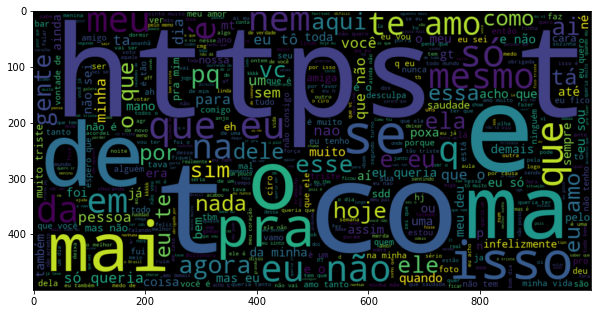

In [42]:
plot_wordcloud(df_train_eda.loc[df_train_eda['sentiment'] == 0, 'tweet_text'])

#### 3.4.2 Sentimento positivo

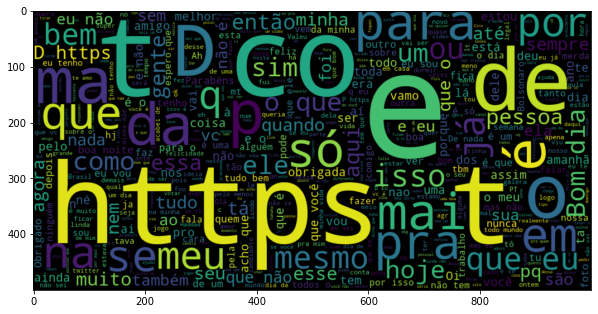

In [43]:
plot_wordcloud(df_train_eda.loc[df_train_eda['sentiment'] == 1, 'tweet_text'])

#### 3.4.3 Sentimento neutro

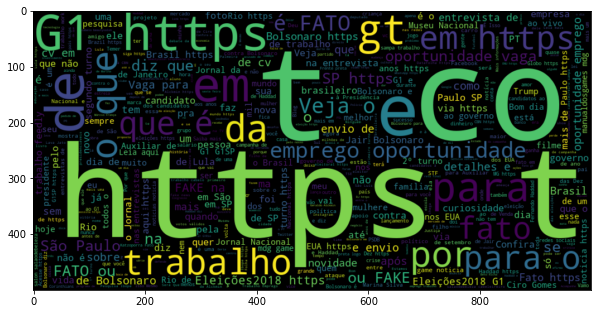

In [44]:
plot_wordcloud(df_train_eda.loc[df_train_eda['sentiment'] == 2, 'tweet_text'])

Além de "https" que se destaca nas três nuvens de palavras, aparecem outros termos que agregam pouco significado, dificultando a análise.   
Portanto, vamos removê-los utilizando algumas funções, "stop_words", além de deixar todos os textos em letras minúsculas.

In [45]:
# Função para remover link de um texto
def clean_url(texts):
    return texts.replace(r'http\S+', '', regex=True)

In [46]:
# Removendo os links dos textos
df_train_eda['tweet_text'] = clean_url(df_train_eda['tweet_text'])

In [47]:
# Verificando se ainda há "http" nos textos
df_train_eda[df_train_eda['tweet_text'].str.contains('http')]

,id,tweet_text,tweet_date,sentiment,query_used,num_caracteres,num_palavras


In [48]:
# Função para deixar um texto em letras minúsculas
def normalize_texts(texts):
    return texts.str.lower()

In [49]:
# Deixando os textos em letras minúsculas
df_train_eda['tweet_text'] = normalize_texts(df_train_eda['tweet_text'])

In [50]:
# Pegando as "stop words" em português
pt_stopwords = stopwords.words('portuguese')
pt_stopwords

['de',
 'a',
 'o',
 'que',
 'e',
 'é',
 'do',
 'da',
 'em',
 'um',
 'para',
 'com',
 'não',
 'uma',
 'os',
 'no',
 'se',
 'na',
 'por',
 'mais',
 'as',
 'dos',
 'como',
 'mas',
 'ao',
 'ele',
 'das',
 'à',
 'seu',
 'sua',
 'ou',
 'quando',
 'muito',
 'nos',
 'já',
 'eu',
 'também',
 'só',
 'pelo',
 'pela',
 'até',
 'isso',
 'ela',
 'entre',
 'depois',
 'sem',
 'mesmo',
 'aos',
 'seus',
 'quem',
 'nas',
 'me',
 'esse',
 'eles',
 'você',
 'essa',
 'num',
 'nem',
 'suas',
 'meu',
 'às',
 'minha',
 'numa',
 'pelos',
 'elas',
 'qual',
 'nós',
 'lhe',
 'deles',
 'essas',
 'esses',
 'pelas',
 'este',
 'dele',
 'tu',
 'te',
 'vocês',
 'vos',
 'lhes',
 'meus',
 'minhas',
 'teu',
 'tua',
 'teus',
 'tuas',
 'nosso',
 'nossa',
 'nossos',
 'nossas',
 'dela',
 'delas',
 'esta',
 'estes',
 'estas',
 'aquele',
 'aquela',
 'aqueles',
 'aquelas',
 'isto',
 'aquilo',
 'estou',
 'está',
 'estamos',
 'estão',
 'estive',
 'esteve',
 'estivemos',
 'estiveram',
 'estava',
 'estávamos',
 'estavam',
 'estivera'

In [51]:
# Função para remover as "stop words"
def clean_pt_stopwords(texts):
    clean_text = r'\b(?:{})\b'.format('|'.join(pt_stopwords))
    return texts.replace(clean_text, '', regex=True)

In [52]:
# Removendo as "stop words"
df_train_eda['new_tweet_text'] = clean_pt_stopwords(df_train_eda['tweet_text'])

In [53]:
pd.set_option('display.max_colwidth', None)
df_train_eda.head()

,id,tweet_text,tweet_date,sentiment,query_used,num_caracteres,num_palavras,new_tweet_text
43311,1047562047054127107,"meu pai vai votar no cabo daciolo, disse que é melhor do que jogar o voto dele fora :)",2018-10-03 19:00:29+00:00,1,:),86,19,"pai vai votar cabo daciolo, disse melhor jogar voto :)"
83346,1049305280616456193,"me perdoa bebê, tem dias que eu não abro o wpp, estou esperando a sensação ruim que eu estou sentindo no peito passar :( não quero ser chata com ninguém, muito menos contigo :(",2018-10-08 14:27:28+00:00,0,:(,177,34,"perdoa bebê, dias abro wpp, esperando sensação ruim sentindo peito passar :( quero ser chata ninguém, menos contigo :("
78821,1050771464515985409,"$245, 2 cds + 2 dvds. saludos :)",2018-10-12 15:33:34+00:00,1,:),35,8,"$245, 2 cds + 2 dvds. saludos :)"
31205,1040684108836417537,#tveja,2018-09-14 19:30:01+00:00,2,veja,30,2,#tveja
63392,1045437815503421441,bem. águas flávias :),2018-09-27 22:19:33+00:00,1,:),21,4,bem. águas flávias :)


No primeiro registro, percebe-se que a palavra "fora" foi excluída do texto.   
Pensando em contextos políticos, por exemplo, em que essa palavra pode ter um significado relevante, talvez seja prudente removê-la das "stop words".

In [54]:
pt_stopwords.remove('fora')
pt_stopwords

['de',
 'a',
 'o',
 'que',
 'e',
 'é',
 'do',
 'da',
 'em',
 'um',
 'para',
 'com',
 'não',
 'uma',
 'os',
 'no',
 'se',
 'na',
 'por',
 'mais',
 'as',
 'dos',
 'como',
 'mas',
 'ao',
 'ele',
 'das',
 'à',
 'seu',
 'sua',
 'ou',
 'quando',
 'muito',
 'nos',
 'já',
 'eu',
 'também',
 'só',
 'pelo',
 'pela',
 'até',
 'isso',
 'ela',
 'entre',
 'depois',
 'sem',
 'mesmo',
 'aos',
 'seus',
 'quem',
 'nas',
 'me',
 'esse',
 'eles',
 'você',
 'essa',
 'num',
 'nem',
 'suas',
 'meu',
 'às',
 'minha',
 'numa',
 'pelos',
 'elas',
 'qual',
 'nós',
 'lhe',
 'deles',
 'essas',
 'esses',
 'pelas',
 'este',
 'dele',
 'tu',
 'te',
 'vocês',
 'vos',
 'lhes',
 'meus',
 'minhas',
 'teu',
 'tua',
 'teus',
 'tuas',
 'nosso',
 'nossa',
 'nossos',
 'nossas',
 'dela',
 'delas',
 'esta',
 'estes',
 'estas',
 'aquele',
 'aquela',
 'aqueles',
 'aquelas',
 'isto',
 'aquilo',
 'estou',
 'está',
 'estamos',
 'estão',
 'estive',
 'esteve',
 'estivemos',
 'estiveram',
 'estava',
 'estávamos',
 'estavam',
 'estivera'

In [55]:
# Adicionando na lista "pt_stopwords" alguns termos irrelevantes que se destacaram nas nuvens de palavras
new_words = ['q', 'pra', 'd', 'p']
for word in new_words:
    pt_stopwords.append(word)
    
pt_stopwords

['de',
 'a',
 'o',
 'que',
 'e',
 'é',
 'do',
 'da',
 'em',
 'um',
 'para',
 'com',
 'não',
 'uma',
 'os',
 'no',
 'se',
 'na',
 'por',
 'mais',
 'as',
 'dos',
 'como',
 'mas',
 'ao',
 'ele',
 'das',
 'à',
 'seu',
 'sua',
 'ou',
 'quando',
 'muito',
 'nos',
 'já',
 'eu',
 'também',
 'só',
 'pelo',
 'pela',
 'até',
 'isso',
 'ela',
 'entre',
 'depois',
 'sem',
 'mesmo',
 'aos',
 'seus',
 'quem',
 'nas',
 'me',
 'esse',
 'eles',
 'você',
 'essa',
 'num',
 'nem',
 'suas',
 'meu',
 'às',
 'minha',
 'numa',
 'pelos',
 'elas',
 'qual',
 'nós',
 'lhe',
 'deles',
 'essas',
 'esses',
 'pelas',
 'este',
 'dele',
 'tu',
 'te',
 'vocês',
 'vos',
 'lhes',
 'meus',
 'minhas',
 'teu',
 'tua',
 'teus',
 'tuas',
 'nosso',
 'nossa',
 'nossos',
 'nossas',
 'dela',
 'delas',
 'esta',
 'estes',
 'estas',
 'aquele',
 'aquela',
 'aqueles',
 'aquelas',
 'isto',
 'aquilo',
 'estou',
 'está',
 'estamos',
 'estão',
 'estive',
 'esteve',
 'estivemos',
 'estiveram',
 'estava',
 'estávamos',
 'estavam',
 'estivera'

In [56]:
# Removendo as "stop words" com os novos termos inseridos na lista
df_train_eda['new_tweet_text'] = clean_pt_stopwords(df_train_eda['tweet_text'])

#### 3.4.4 Sentimento negativo (após tratamento dos dados)

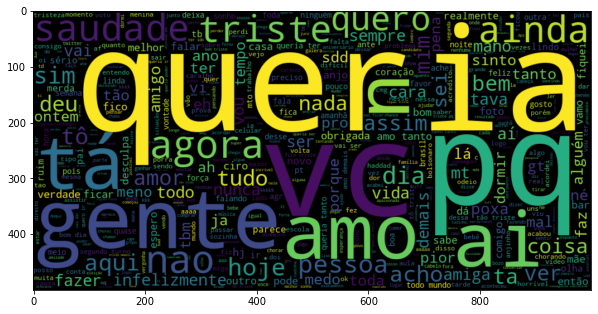

In [57]:
plot_wordcloud(df_train_eda.loc[df_train_eda['sentiment'] == 0, 'new_tweet_text'])

Alguns tweets que me chamaram a atenção foram os que possuem a palavra "amo" ou a expressão "amo você".

In [58]:
df_train_eda[df_train_eda['tweet_text'].str.contains('amo')]['sentiment'].value_counts()

0    2720
1    1965
2    1182
Name: sentiment, dtype: int64

In [59]:
df_train_eda[df_train_eda['tweet_text'].str.contains('amo você')]['sentiment'].value_counts()

0    58
1    12
2     1
Name: sentiment, dtype: int64

O fato de aparecer essa palavra ou expressão nos textos, automaticamente, faz com que eu as associe a um sentimento positivo. Porém, na maioria das vezes, elas aparecem ao lado de um emoticon de tristeza, ou seja, um sentimento negativo.

Ao "plotar" a nuvem de palavras relacionadas ao sentimento negativo, a princípio, imaginei que encontraria muitos termos que demonstrassem indignação, raiva, além de tristeza.
No entanto, se analisarmos essa nuvem, nota-se palavras como: "queria", "amo", "agora", "saudade", "quero", "ainda" etc.
Ou seja, parece que, com esses dados, o sentimento negativo está mais associado à nostalgia ou a um anseio de se obter aquilo que deseja.   
Isso explicaria o fato de "amo" ou "amo você" estarem associadas a um sentimento negativo, como visto nas análises acima.

#### 3.4.5 Sentimento positivo (após tratamento dos dados)

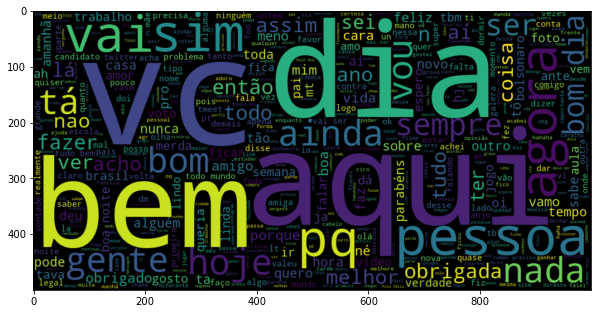

In [60]:
plot_wordcloud(df_train_eda.loc[df_train_eda['sentiment'] == 1, 'new_tweet_text'])

#### 3.4.6 Sentimento neutro (após tratamento dos dados)

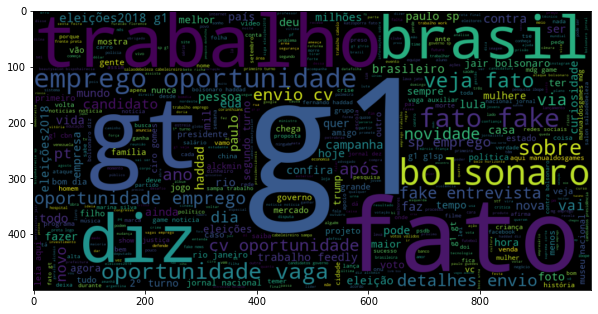

In [61]:
plot_wordcloud(df_train_eda.loc[df_train_eda['sentiment'] == 2, 'new_tweet_text'])

### 3.5 Análise temporal

In [62]:
df_train_eda['y_m_d'] = df_train_eda['tweet_date'].dt.strftime('%Y%m%d')

df_train_eda.head()

,id,tweet_text,tweet_date,sentiment,query_used,num_caracteres,num_palavras,new_tweet_text,y_m_d
43311,1047562047054127107,"meu pai vai votar no cabo daciolo, disse que é melhor do que jogar o voto dele fora :)",2018-10-03 19:00:29+00:00,1,:),86,19,"pai vai votar cabo daciolo, disse melhor jogar voto fora :)",20181003
83346,1049305280616456193,"me perdoa bebê, tem dias que eu não abro o wpp, estou esperando a sensação ruim que eu estou sentindo no peito passar :( não quero ser chata com ninguém, muito menos contigo :(",2018-10-08 14:27:28+00:00,0,:(,177,34,"perdoa bebê, dias abro wpp, esperando sensação ruim sentindo peito passar :( quero ser chata ninguém, menos contigo :(",20181008
78821,1050771464515985409,"$245, 2 cds + 2 dvds. saludos :)",2018-10-12 15:33:34+00:00,1,:),35,8,"$245, 2 cds + 2 dvds. saludos :)",20181012
31205,1040684108836417537,#tveja,2018-09-14 19:30:01+00:00,2,veja,30,2,#tveja,20180914
63392,1045437815503421441,bem. águas flávias :),2018-09-27 22:19:33+00:00,1,:),21,4,bem. águas flávias :),20180927


In [63]:
df_historic = df_train_eda.groupby(['y_m_d', 'sentiment'])[['tweet_date']].count().reset_index()

df_historic.head()

,y_m_d,sentiment,tweet_date
0,20180809,2,1
1,20180817,2,202
2,20180818,2,185
3,20180819,2,147
4,20180820,2,287


In [64]:
pivot = pd.pivot_table(df_historic, values='tweet_date', index='y_m_d', columns='sentiment').fillna(0)

pivot.head()

sentiment,0,1,2
y_m_d,,,
20180809,0.0,0.0,1.0
20180817,0.0,0.0,202.0
20180818,0.0,0.0,185.0
20180819,0.0,0.0,147.0
20180820,0.0,0.0,287.0


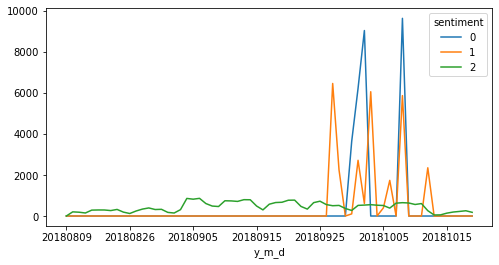

In [65]:
pivot.plot(figsize=(8, 4))
plt.show()

Percebe-se que os sentimentos negativos e positivos são identificados apenas em um relativo curto período de tempo.   
Lembrando que, nesse período, houve um grande movimento de debates em relação à eleição de 2018, não só na mídia como também em reuniões entre amigos, familiares, em instituições de ensino, no trabalho etc.

In [66]:
for coluna in pivot.columns:
    pivot[coluna] = pivot[coluna].rolling(15).mean()
    
pivot.head()

sentiment,0,1,2
y_m_d,,,
20180809,NaN,NaN,NaN
20180817,NaN,NaN,NaN
20180818,NaN,NaN,NaN
20180819,NaN,NaN,NaN
20180820,NaN,NaN,NaN


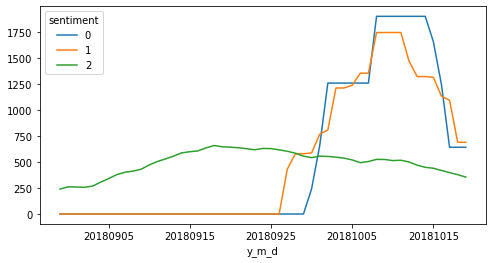

In [67]:
# Verificando a média dos sentimentos em intervalos de 15 dias
pivot.plot(figsize=(8, 4))
plt.show()

In [68]:
# Verificando uma amostra dos dados em relação aos sentimentos positivos e negativos, após o 1º turno da eleição de 2018,
# para ver se há debates sobre política.
df_train_eda[(df_train_eda['sentiment'] != 2) & (df_train_eda['y_m_d'] >= '20181007')].sample(10)

,id,tweet_text,tweet_date,sentiment,query_used,num_caracteres,num_palavras,new_tweet_text,y_m_d
10931,1049104388046966784,tomei sim :)) esperoo boe obgg,2018-10-08 01:09:12+00:00,1,:),31,6,tomei sim :)) esperoo boe obgg,20181008
62730,1049138584895283201,"eu não consigo nem pensar em ter um melhor amigo(a) que vote nesse ser. pq pra votar nele tem que concordar pelo menos um pouco com o modo dele de pensar, e eu sou meio que muita coisa que ele odeia. então nem teria como estabelecer uma amizade com alguém que apóia. :p",2018-10-08 03:25:05+00:00,1,:),270,53,"consigo pensar ter melhor amigo() vote nesse ser. pq votar nele concordar menos pouco modo pensar, meio muita coisa odeia. então estabelecer amizade alguém apóia. :",20181008
94973,1050744223627137026,oi mauro. gosto muito do seu trabalho e das suas criticas. mas o flamengo também tem esse lado mais humano :d e sem o bandeira ^^ então hj chega de criticas :d,2018-10-12 13:45:19+00:00,1,:),161,32,oi mauro. gosto trabalho criticas. flamengo lado humano : bandeira ^^ então hj chega criticas :,20181012
94715,1050760997949136896,"bom dia, galerinha!! uma ótema sexta-feira a todos nós e feliz dia das crianças!! :d....",2018-10-12 14:51:58+00:00,1,:),88,15,"bom dia, galerinha!! ótema sexta-feira todos feliz dia crianças!! :....",20181012
36708,1049135485417869312,alguém me diz algumas músicas boas pra eu ouvir amanhã?? n quero ouvir meus coleguinhas cagar pela boca :),2018-10-08 03:12:46+00:00,1,:),106,19,alguém diz algumas músicas boas ouvir amanhã?? n quero ouvir coleguinhas cagar boca :),20181008
40831,1049274674763522048,aí num pode. :(,2018-10-08 12:25:51+00:00,0,:(,16,4,aí pode. :(,20181008
45548,1049307983493181440,intelecto maior que o seu :p,2018-10-08 14:38:13+00:00,1,:),29,6,intelecto maior :,20181008
55377,1049277891236773888,olha a carinha do meu nenem :(,2018-10-08 12:38:38+00:00,0,:(,54,8,olha carinha nenem :(,20181008
70529,1049103855072550912,qual profissão deveria ser mais valorizada? — professor :),2018-10-08 01:07:05+00:00,1,:),82,10,profissão deveria ser valorizada? — professor :),20181008
67603,1049222676596908033,"kkkkk age como se a ditadura fosse algo lindo, triste ver a falta de conhecimento alheio :)",2018-10-08 08:59:14+00:00,1,:),93,17,"kkkkk age ditadura algo lindo, triste ver falta conhecimento alheio :)",20181008


## 4. Pré-processamento e modelagem

In [69]:
X = df_train['tweet_text']
y = df_train['sentiment']

X = clean_username(X)
X = clean_url(X)
X = normalize_texts(X)
X = clean_pt_stopwords(X)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=.2, random_state=2022)

print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)

(68400,) (68400,)
(17100,) (17100,)


In [70]:
def score_train(y_train, y_train_pred):

    acc_train = accuracy_score(y_train, y_train_pred)
    prec_train = precision_score(y_train, y_train_pred, average='macro')
    rec_train = recall_score(y_train, y_train_pred, average='macro')

    print(f'Treino:\nAcc: {acc_train:.2f}, Precision: {prec_train:.2f}, Recall: {rec_train:.2f}')
    
def score_valid(y_valid, y_valid_pred):
    
    acc_valid = accuracy_score(y_valid, y_valid_pred)
    prec_valid = precision_score(y_valid, y_valid_pred, average='macro')
    rec_valid = recall_score(y_valid, y_valid_pred, average='macro')
    
    print(f'Validação:\nAcc: {acc_valid:.2f}, Precision: {prec_valid:.2f}, Recall: {rec_valid:.2f}')
    
def score_test(y_test, y_test_pred):
    
    acc_test = accuracy_score(y_test, y_test_pred)
    prec_test = precision_score(y_test, y_test_pred, average='macro')
    rec_test = recall_score(y_test, y_test_pred, average='macro')

    print(f'Teste:\nAcc: {acc_test:.2f}, Precision: {prec_test:.2f}, Recall: {rec_test:.2f}')
    
def plot_cm(y, y_pred, names):
    
    cm = confusion_matrix(y, y_pred)

    fig, ax = plot_confusion_matrix(conf_mat=cm, class_names=names)

    fig.set_size_inches(5, 5)

    plt.show()

### 4.1 Bag Of Words

In [71]:
vectorizer = CountVectorizer(max_features=10000)

vectorizer.fit(X_train)
    
X_train_transformed = vectorizer.transform(X_train).toarray()
print(X_train_transformed.shape)

X_valid_transformed = vectorizer.transform(X_valid).toarray()
print(X_valid_transformed.shape)

(68400, 10000)
(17100, 10000)


#### 4.1.1 Random Forest

In [72]:
modelo = RandomForestClassifier(max_depth=5, random_state=2022)

modelo.fit(X_train_transformed, y_train)

RandomForestClassifier(max_depth=5, random_state=2022)

In [73]:
y_train_pred = modelo.predict(X_train_transformed)

y_valid_pred = modelo.predict(X_valid_transformed)

print(y_train_pred.shape, y_valid_pred.shape)

(68400,) (17100,)


In [74]:
score_train(y_train, y_train_pred)

score_valid(y_valid, y_valid_pred)

Treino:
Acc: 0.68, Precision: 0.73, Recall: 0.68
Validação:
Acc: 0.68, Precision: 0.73, Recall: 0.68


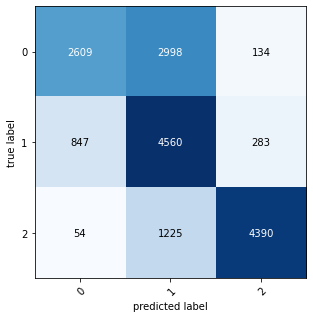

In [75]:
plot_cm(y_valid, y_valid_pred, modelo.classes_)

##### 4.1.1.1 Inferência na base de teste

In [76]:
X_test = df_test['tweet_text']
y_test = df_test['sentiment']

X_test = clean_username(X_test)
X_test = clean_url(X_test)
X_test = normalize_texts(X_test)
X_test = clean_pt_stopwords(X_test)

print(X_test.shape, y_test.shape)

(9500,) (9500,)


In [77]:
X_test_transformed = vectorizer.transform(X_test).toarray()

print(X_test_transformed.shape)

(9500, 10000)


In [78]:
y_test_pred = modelo.predict(X_test_transformed)

print(y_test_pred.shape)

(9500,)


In [79]:
mean_absolute_error(y_test, y_test_pred)

0.33673684210526317

In [80]:
score_test(y_test, y_test_pred)

Teste:
Acc: 0.67, Precision: 0.73, Recall: 0.68


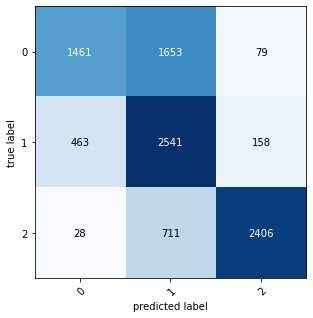

In [81]:
plot_cm(y_test, y_test_pred, modelo.classes_)

#### 4.1.2 LightGBM

In [82]:
modelo = LGBMClassifier(random_state=2022)

modelo.fit(X_train_transformed, y_train)

LGBMClassifier(random_state=2022)

In [83]:
y_train_pred = modelo.predict(X_train_transformed)

y_valid_pred = modelo.predict(X_valid_transformed)

print(y_train_pred.shape, y_valid_pred.shape)

(68400,) (17100,)


In [84]:
score_train(y_train, y_train_pred)

score_valid(y_valid, y_valid_pred)

Treino:
Acc: 0.79, Precision: 0.80, Recall: 0.79
Validação:
Acc: 0.77, Precision: 0.78, Recall: 0.77


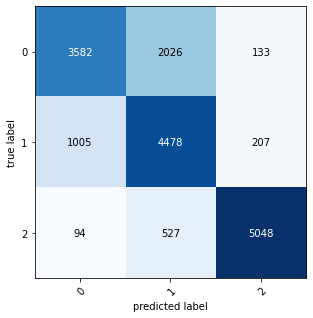

In [85]:
plot_cm(y_valid, y_valid_pred, modelo.classes_)

##### 4.1.2.1 Inferência na base de teste

In [86]:
X_test_transformed = vectorizer.transform(X_test).toarray()

print(X_test_transformed.shape)

(9500, 10000)


In [87]:
y_test_pred = modelo.predict(X_test_transformed)

print(y_test_pred.shape)

(9500,)


In [88]:
mean_absolute_error(y_test, y_test_pred)

0.24673684210526317

In [89]:
score_test(y_test, y_test_pred)

Teste:
Acc: 0.77, Precision: 0.78, Recall: 0.77


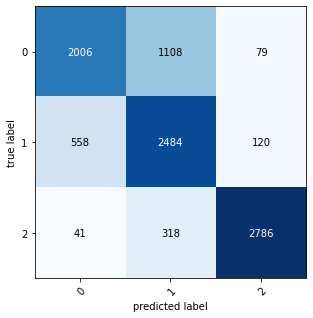

In [90]:
plot_cm(y_test, y_test_pred, modelo.classes_)

##### 4.1.2.2 LightGBM com otimização

In [91]:
modelo = LGBMClassifier()

parameters = {
    'max_depth': [10, 20],
    'n_estimators': [200, 300],
    'learning_rate': [0.1, 0.5]
}

clf = GridSearchCV(modelo, parameters, verbose=3, scoring='accuracy', cv=3)

clf.fit(X_train_transformed, y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV 1/3] END learning_rate=0.1, max_depth=10, n_estimators=200;, score=0.757 total time=   9.3s
[CV 2/3] END learning_rate=0.1, max_depth=10, n_estimators=200;, score=0.762 total time=   9.3s
[CV 3/3] END learning_rate=0.1, max_depth=10, n_estimators=200;, score=0.761 total time=   8.4s
[CV 1/3] END learning_rate=0.1, max_depth=10, n_estimators=300;, score=0.770 total time=   8.1s
[CV 2/3] END learning_rate=0.1, max_depth=10, n_estimators=300;, score=0.771 total time=   9.0s
[CV 3/3] END learning_rate=0.1, max_depth=10, n_estimators=300;, score=0.771 total time=   8.3s
[CV 1/3] END learning_rate=0.1, max_depth=20, n_estimators=200;, score=0.776 total time=  10.2s
[CV 2/3] END learning_rate=0.1, max_depth=20, n_estimators=200;, score=0.778 total time=  11.1s
[CV 3/3] END learning_rate=0.1, max_depth=20, n_estimators=200;, score=0.776 total time=   8.3s
[CV 1/3] END learning_rate=0.1, max_depth=20, n_estimators=300;, score=0.781

GridSearchCV(cv=3, estimator=LGBMClassifier(),
             param_grid={'learning_rate': [0.1, 0.5], 'max_depth': [10, 20],
                         'n_estimators': [200, 300]},
             scoring='accuracy', verbose=3)

In [92]:
clf.best_params_

{'learning_rate': 0.5, 'max_depth': 20, 'n_estimators': 200}

In [93]:
modelo = LGBMClassifier(**clf.best_params_)

modelo.fit(X_train_transformed, y_train)

LGBMClassifier(learning_rate=0.5, max_depth=20, n_estimators=200)

In [94]:
y_train_pred = modelo.predict(X_train_transformed)

y_valid_pred = modelo.predict(X_valid_transformed)

print(y_train_pred.shape, y_valid_pred.shape)

(68400,) (17100,)


In [95]:
score_train(y_train, y_train_pred)

score_valid(y_valid, y_valid_pred)

Treino:
Acc: 0.86, Precision: 0.87, Recall: 0.86
Validação:
Acc: 0.80, Precision: 0.80, Recall: 0.80


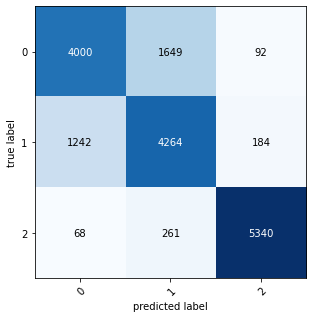

In [96]:
plot_cm(y_valid, y_valid_pred, modelo.classes_)

##### 4.1.2.3 Inferência na base de teste

In [97]:
X_test_transformed = vectorizer.transform(X_test).toarray()

print(X_test_transformed.shape)

(9500, 10000)


In [98]:
y_test_pred = modelo.predict(X_test_transformed)

print(y_test_pred.shape)

(9500,)


In [99]:
mean_absolute_error(y_test, y_test_pred)

0.2128421052631579

In [100]:
score_test(y_test, y_test_pred)

Teste:
Acc: 0.80, Precision: 0.80, Recall: 0.80


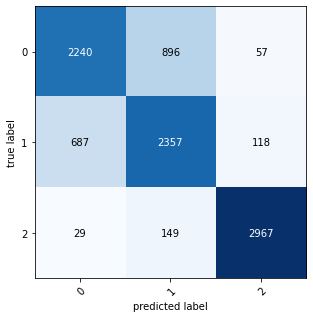

In [101]:
plot_cm(y_test, y_test_pred, modelo.classes_)

##### 4.1.2.4 LightGBM com ajuste manual dos hiperparâmetros

In [102]:
modelo = LGBMClassifier(max_depth=20, n_estimators=300, random_state=2022)

modelo.fit(X_train_transformed, y_train)

LGBMClassifier(max_depth=20, n_estimators=300, random_state=2022)

In [103]:
y_train_pred = modelo.predict(X_train_transformed)

y_valid_pred = modelo.predict(X_valid_transformed)

print(y_train_pred.shape, y_valid_pred.shape)

(68400,) (17100,)


In [104]:
score_train(y_train, y_train_pred)

score_valid(y_valid, y_valid_pred)

Treino:
Acc: 0.82, Precision: 0.83, Recall: 0.82
Validação:
Acc: 0.79, Precision: 0.79, Recall: 0.79


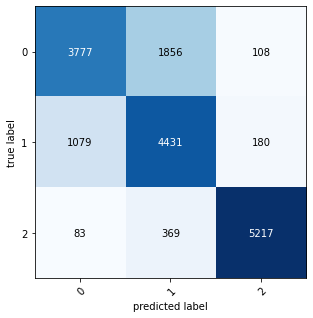

In [105]:
plot_cm(y_valid, y_valid_pred, modelo.classes_)

##### 4.1.2.5 Inferência na base de teste

In [106]:
X_test_transformed = vectorizer.transform(X_test).toarray()

print(X_test_transformed.shape)

(9500, 10000)


In [107]:
y_test_pred = modelo.predict(X_test_transformed)

print(y_test_pred.shape)

(9500,)


In [108]:
mean_absolute_error(y_test, y_test_pred)

0.22547368421052633

In [109]:
score_test(y_test, y_test_pred)

Teste:
Acc: 0.78, Precision: 0.79, Recall: 0.79


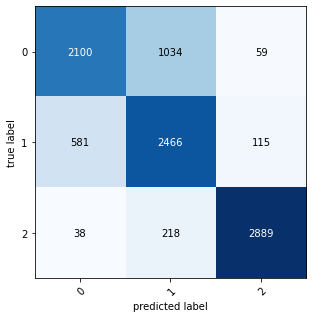

In [110]:
plot_cm(y_test, y_test_pred, modelo.classes_)

#### 4.1.3 Naive Bayes

In [111]:
modelo = MultinomialNB()

modelo.fit(X_train_transformed, y_train)

MultinomialNB()

In [112]:
y_train_pred = modelo.predict(X_train_transformed)

y_valid_pred = modelo.predict(X_valid_transformed)

print(y_train_pred.shape, y_valid_pred.shape)

(68400,) (17100,)


In [113]:
score_train(y_train, y_train_pred)

score_valid(y_valid, y_valid_pred)

Treino:
Acc: 0.82, Precision: 0.82, Recall: 0.82
Validação:
Acc: 0.79, Precision: 0.79, Recall: 0.79


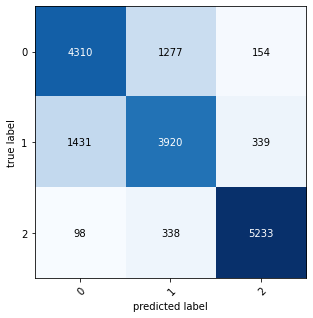

In [114]:
plot_cm(y_valid, y_valid_pred, modelo.classes_)

##### 4.1.3.1 Inferência na base de teste

In [115]:
X_test_transformed = vectorizer.transform(X_test).toarray()

print(X_test_transformed.shape)

(9500, 10000)


In [116]:
y_test_pred = modelo.predict(X_test_transformed)

print(y_test_pred.shape)

(9500,)


In [117]:
mean_absolute_error(y_test, y_test_pred)

0.22642105263157894

In [118]:
score_test(y_test, y_test_pred)

Teste:
Acc: 0.79, Precision: 0.79, Recall: 0.79


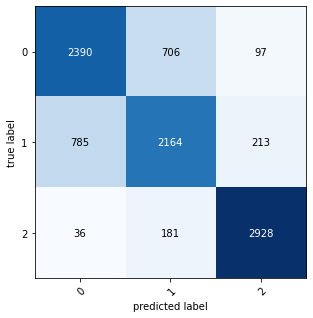

In [119]:
plot_cm(y_test, y_test_pred, modelo.classes_)

### 4.2 TF-IDF

In [120]:
vectorizer = TfidfVectorizer(max_features=10000)

vectorizer.fit(X_train)
    
X_train_transformed = vectorizer.transform(X_train).toarray()
print(X_train_transformed.shape)

X_valid_transformed = vectorizer.transform(X_valid).toarray()
print(X_valid_transformed.shape)

(68400, 10000)
(17100, 10000)


#### 4.2.1 Random Forest

In [121]:
modelo = RandomForestClassifier(max_depth=5, random_state=2022)

modelo.fit(X_train_transformed, y_train)

RandomForestClassifier(max_depth=5, random_state=2022)

In [122]:
y_train_pred = modelo.predict(X_train_transformed)

y_valid_pred = modelo.predict(X_valid_transformed)

print(y_train_pred.shape, y_valid_pred.shape)

(68400,) (17100,)


In [123]:
score_train(y_train, y_train_pred)

score_valid(y_valid, y_valid_pred)

Treino:
Acc: 0.69, Precision: 0.74, Recall: 0.69
Validação:
Acc: 0.68, Precision: 0.73, Recall: 0.68


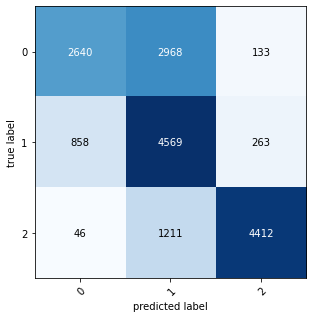

In [124]:
plot_cm(y_valid, y_valid_pred, modelo.classes_)

##### 4.2.1.1 Inferência na base de teste

In [125]:
X_test_transformed = vectorizer.transform(X_test).toarray()

print(X_test_transformed.shape)

(9500, 10000)


In [126]:
y_test_pred = modelo.predict(X_test_transformed)

print(y_test_pred.shape)

(9500,)


In [127]:
mean_absolute_error(y_test, y_test_pred)

0.32894736842105265

In [128]:
score_test(y_test, y_test_pred)

Teste:
Acc: 0.68, Precision: 0.73, Recall: 0.68


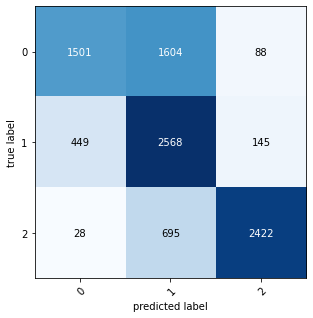

In [129]:
plot_cm(y_test, y_test_pred, modelo.classes_)

#### 4.2.2 LightGBM

In [130]:
modelo = LGBMClassifier(random_state=2022)

modelo.fit(X_train_transformed, y_train)

LGBMClassifier(random_state=2022)

In [131]:
y_train_pred = modelo.predict(X_train_transformed)

y_valid_pred = modelo.predict(X_valid_transformed)

print(y_train_pred.shape, y_valid_pred.shape)

(68400,) (17100,)


In [132]:
score_train(y_train, y_train_pred)

score_valid(y_valid, y_valid_pred)

Treino:
Acc: 0.80, Precision: 0.81, Recall: 0.80
Validação:
Acc: 0.77, Precision: 0.79, Recall: 0.77


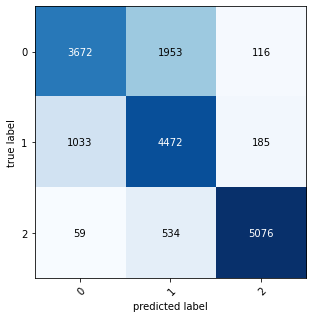

In [133]:
plot_cm(y_valid, y_valid_pred, modelo.classes_)

##### 4.2.2.1 Inferência na base de teste

In [134]:
X_test_transformed = vectorizer.transform(X_test).toarray()

print(X_test_transformed.shape)

(9500, 10000)


In [135]:
y_test_pred = modelo.predict(X_test_transformed)

print(y_test_pred.shape)

(9500,)


In [136]:
mean_absolute_error(y_test, y_test_pred)

0.2423157894736842

In [137]:
score_test(y_test, y_test_pred)

Teste:
Acc: 0.77, Precision: 0.78, Recall: 0.77


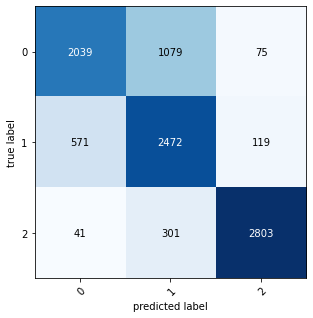

In [138]:
plot_cm(y_test, y_test_pred, modelo.classes_)

#### 4.2.3 Naive Bayes

In [139]:
modelo = MultinomialNB()

modelo.fit(X_train_transformed, y_train)

MultinomialNB()

In [140]:
y_train_pred = modelo.predict(X_train_transformed)

y_valid_pred = modelo.predict(X_valid_transformed)

print(y_train_pred.shape, y_valid_pred.shape)

(68400,) (17100,)


In [141]:
score_train(y_train, y_train_pred)

score_valid(y_valid, y_valid_pred)

Treino:
Acc: 0.82, Precision: 0.82, Recall: 0.82
Validação:
Acc: 0.78, Precision: 0.78, Recall: 0.78


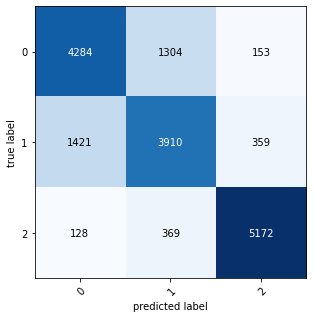

In [142]:
plot_cm(y_valid, y_valid_pred, modelo.classes_)

##### 4.2.3.1 Inferência na base de teste

In [143]:
X_test_transformed = vectorizer.transform(X_test).toarray()

print(X_test_transformed.shape)

(9500, 10000)


In [144]:
y_test_pred = modelo.predict(X_test_transformed)

print(y_test_pred.shape)

(9500,)


In [145]:
mean_absolute_error(y_test, y_test_pred)

0.23189473684210526

In [146]:
score_test(y_test, y_test_pred)

Teste:
Acc: 0.78, Precision: 0.78, Recall: 0.78


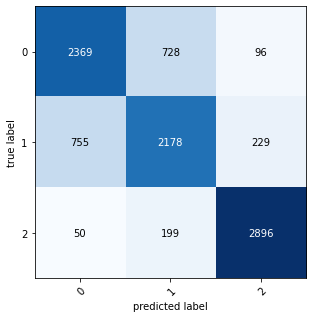

In [147]:
plot_cm(y_test, y_test_pred, modelo.classes_)

### 4.3 Word2Vec

In [148]:
# Função para quebrar um texto em palavras
def tokenize(text):
    return simple_preprocess(text, min_len=1)

def to_word_vector(words, w2v):

    vectors = []

    for word in words:
        vectors.append(w2v.wv[word] if word in w2v.wv.key_to_index else np.zeros(w2v.vector_size))
        
    if not vectors:
        vectors.append(np.zeros(w2v.vector_size))
    
    return np.mean(vectors, axis=0)

def embeddings(x, w2v):
    x = x.copy()

    x = x.apply(tokenize)

    x = np.vstack([[to_word_vector(sentences, w2v)] for sentences in tqdm(x)])

    return x

In [149]:
# Versão mais recente do gensim: parâmetro size virou vector_size
model_w2v = Word2Vec(
        sentences=X_train.apply(
            lambda t: tokenize(t)
        ),
         vector_size=300, # número de features
         window=5,
         min_count=1,
         workers=4
    )

In [150]:
# Número de palavras
len(model_w2v.wv)

50745

In [151]:
model_w2v.wv.key_to_index

{'g': 0,
 'trabalho': 1,
 'dia': 2,
 'vai': 3,
 'fato': 4,
 'bolsonaro': 5,
 'vou': 6,
 'ser': 7,
 'to': 8,
 'bem': 9,
 'queria': 10,
 'diz': 11,
 'vc': 12,
 'oportunidade': 13,
 'gt': 14,
 'ter': 15,
 'bom': 16,
 'tá': 17,
 'tudo': 18,
 'gente': 19,
 'aqui': 20,
 'pq': 21,
 'agora': 22,
 'hoje': 23,
 'n': 24,
 'fazer': 25,
 'ainda': 26,
 'sobre': 27,
 'emprego': 28,
 'ver': 29,
 'tão': 30,
 'triste': 31,
 'tô': 32,
 'eleições': 33,
 'amo': 34,
 'sim': 35,
 'brasil': 36,
 'sp': 37,
 'nao': 38,
 'vaga': 39,
 'pode': 40,
 'quero': 41,
 'nada': 42,
 'ai': 43,
 'sei': 44,
 'haddad': 45,
 'sempre': 46,
 'assim': 47,
 'vida': 48,
 'boa': 49,
 'melhor': 50,
 'veja': 51,
 'pessoas': 52,
 'anos': 53,
 'tanto': 54,
 'acho': 55,
 'faz': 56,
 'ir': 57,
 'todos': 58,
 'mundo': 59,
 'nunca': 60,
 'mim': 61,
 'ta': 62,
 'coisa': 63,
 'feliz': 64,
 'amor': 65,
 'novo': 66,
 'e': 67,
 'casa': 68,
 'aí': 69,
 'ficar': 70,
 'todo': 71,
 'após': 72,
 'turno': 73,
 'contra': 74,
 'novidade': 75,
 'ciro': 7

In [152]:
# Verificando se a similaridade entre as palavras faz sentido
model_w2v.wv.most_similar('bom', topn=5)

[('inteiro', 0.9632234573364258),
 ('ótimo', 0.9609524607658386),
 ('cada', 0.9536773562431335),
 ('inteirinho', 0.9407674074172974),
 ('frequencia', 0.9385398626327515)]

In [153]:
model_w2v.wv.most_similar('ruim', topn=5)

[('difícil', 0.9956362843513489),
 ('complicado', 0.9904137849807739),
 ('foda', 0.9902738332748413),
 ('merda', 0.984769880771637),
 ('acontecendo', 0.9839526414871216)]

In [154]:
model_w2v.wv.most_similar('eleição', topn=5)

[('útil', 0.9792302250862122),
 ('globolixo', 0.9720737338066101),
 ('álvaro', 0.9651808738708496),
 ('candidato', 0.9640286564826965),
 ('presidente', 0.9627859592437744)]

In [155]:
model_w2v.wv.most_similar('haddad', topn=5)

[('pt', 0.9918227791786194),
 ('governabilidade', 0.9860545992851257),
 ('voto', 0.9854965209960938),
 ('boulos', 0.9850244522094727),
 ('bolsonaro', 0.983104407787323)]

In [156]:
model_w2v.wv.most_similar('bolsonaro', topn=5)

[('haddad', 0.9831045269966125),
 ('lula', 0.9803621172904968),
 ('alavancar', 0.9801177978515625),
 ('barrar', 0.9795096516609192),
 ('marina', 0.9787560701370239)]

In [157]:
X_train_transformed = embeddings(X_train, model_w2v)

X_valid_transformed = embeddings(X_valid, model_w2v)

100%|█████████████████████████████████████████████████████████████████████████| 17100/17100 [00:00<00:00, 30218.52it/s]


In [158]:
pd.DataFrame(X_train_transformed[:10])

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,-0.046884,0.545185,0.124119,0.197664,0.108461,-0.366275,0.281552,0.825977,0.189865,-0.069179,...,0.049278,0.505028,0.291573,-0.096925,0.335181,0.618274,0.065694,-0.069789,0.234492,0.208438
1,-0.092796,0.516200,-0.152287,0.041727,-0.206665,-0.372497,0.099686,0.023742,-0.088028,-0.264351,...,0.462875,0.610164,0.669699,0.031640,0.195800,0.366865,-0.257459,-0.561805,0.347668,-0.300344
2,-0.062371,0.056218,-0.007276,0.044744,-0.094237,-0.350459,0.005787,0.533332,0.120556,-0.074917,...,0.123929,0.216690,0.346593,0.061920,0.045007,0.186526,0.026497,-0.145276,0.297947,-0.022336
3,-0.015254,0.470102,0.090870,0.245909,0.105488,-0.477800,0.234148,0.962773,0.164396,-0.191503,...,-0.045828,0.390260,0.304912,-0.117338,0.359665,0.602042,0.226329,-0.058597,0.202197,0.207827
4,-0.095440,0.135069,-0.054746,0.078568,0.021274,-0.047393,0.041431,0.111506,0.059503,-0.029917,...,0.076005,0.230659,0.146346,0.074026,0.060295,-0.028775,-0.264629,-0.263565,0.125847,-0.025130
5,-0.048065,0.338624,-0.036668,0.096731,-0.036284,-0.279309,0.132747,0.356165,0.040915,-0.166018,...,0.116653,0.366603,0.318594,0.027968,0.179957,0.334303,-0.068119,-0.227310,0.202188,-0.028337
6,-0.099384,0.508381,0.129548,0.259525,0.100797,-0.416559,0.287469,0.991234,0.210132,-0.134303,...,-0.062136,0.495340,0.245799,-0.061501,0.344428,0.680226,0.111356,-0.070535,0.278575,0.225608
7,-0.003681,0.243667,-0.007002,0.084753,0.025924,-0.186215,0.101848,0.369744,0.054848,-0.120806,...,0.017724,0.227170,0.169777,-0.004001,0.169839,0.287425,0.006341,-0.106301,0.100056,0.051605
8,-0.067265,0.125045,-0.017388,0.077153,-0.074119,-0.251853,0.048583,0.304358,0.028372,-0.098996,...,0.080332,0.232648,0.273662,0.064496,0.078396,0.169170,-0.043829,-0.144244,0.207856,-0.081142
9,-0.020484,0.485949,0.081242,0.201406,0.025800,-0.535698,0.232973,1.156338,0.232858,-0.268910,...,-0.070295,0.429504,0.367091,-0.038573,0.419119,0.710538,0.200709,-0.084222,0.302714,0.255187


### Word embeddings

In [159]:
# Função para "plotar" uma amostra de um conjunto de palavras e observar suas posições para ver se as proximidades fazem sentido
def plot_words(words, model_w2v):
    vocab = [word for word in model_w2v.wv.key_to_index]

    X = model_w2v.wv.vectors

    pca = PCA(n_components=2)
    X_reduct = pca.fit_transform(X)

    df = pd.DataFrame(X_reduct, index=vocab, columns=['x', 'y'])

    if type(words) == int:
        df = df.sample(min(words, len(df)))
    else:
        df = df.loc[words]

    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(1, 1, 1)

    ax.scatter(df['x'], df['y'])

    for word, pos in df.iterrows():
        ax.annotate(word, pos)

    plt.show()

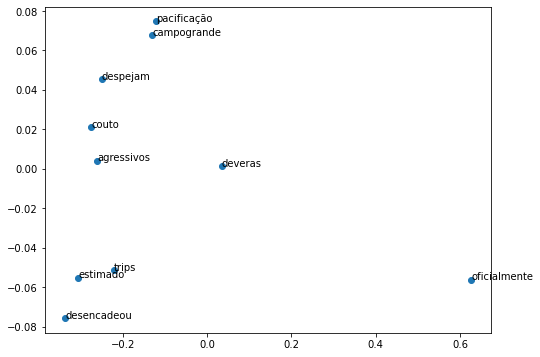

In [160]:
# "Plotando" apenas 10 palavras de um conjunto de 50745
plot_words(10, model_w2v)

"Plotar" apenas 10 palavras de um conjunto de 50745 não parece trazer informações relevantes.

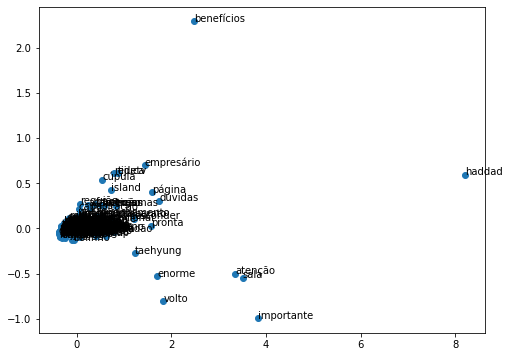

In [161]:
# "Plotando" 200 palavras de um conjunto de 50745
plot_words(200, model_w2v)

"Plotando" 200 palavras, às vezes, damos a "sorte" de observar uma proximidade entre palavras similares, como "jovem" e "novos", que apareceram em uma das vezes em que gerei esse gráfico.

#### 4.3.1 Random Forest

In [162]:
modelo = RandomForestClassifier(max_depth=5, random_state=2022)

modelo.fit(X_train_transformed, y_train)

RandomForestClassifier(max_depth=5, random_state=2022)

In [163]:
y_train_pred = modelo.predict(X_train_transformed)

y_valid_pred = modelo.predict(X_valid_transformed)

print(y_train_pred.shape, y_valid_pred.shape)

(68400,) (17100,)


In [164]:
score_train(y_train, y_train_pred)

score_valid(y_valid, y_valid_pred)

Treino:
Acc: 0.73, Precision: 0.73, Recall: 0.73
Validação:
Acc: 0.71, Precision: 0.72, Recall: 0.71


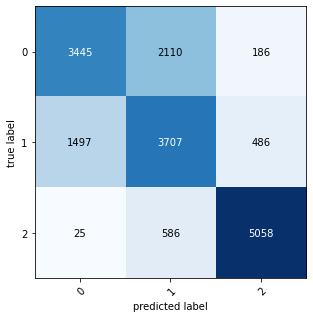

In [165]:
plot_cm(y_valid, y_valid_pred, modelo.classes_)

##### 4.3.1.1 Inferência na base de teste

In [166]:
X_test_transformed = embeddings(X_test, model_w2v)

X_test_transformed.shape

100%|███████████████████████████████████████████████████████████████████████████| 9500/9500 [00:00<00:00, 26299.44it/s]


(9500, 300)

In [167]:
y_test_pred = modelo.predict(X_test_transformed)

print(y_test_pred.shape)

(9500,)


In [168]:
mean_absolute_error(y_test, y_test_pred)

0.29947368421052634

In [169]:
score_test(y_test, y_test_pred)

Teste:
Acc: 0.71, Precision: 0.72, Recall: 0.72


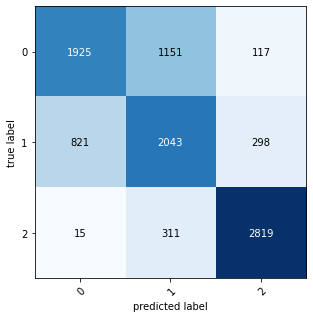

In [170]:
plot_cm(y_test, y_test_pred, modelo.classes_)

#### 4.3.2 LightGBM

In [171]:
modelo = LGBMClassifier(random_state=2022)

modelo.fit(X_train_transformed, y_train)

LGBMClassifier(random_state=2022)

In [172]:
y_train_pred = modelo.predict(X_train_transformed)

y_valid_pred = modelo.predict(X_valid_transformed)

print(y_train_pred.shape, y_valid_pred.shape)

(68400,) (17100,)


In [173]:
score_train(y_train, y_train_pred)

score_valid(y_valid, y_valid_pred)

Treino:
Acc: 0.80, Precision: 0.80, Recall: 0.80
Validação:
Acc: 0.75, Precision: 0.75, Recall: 0.75


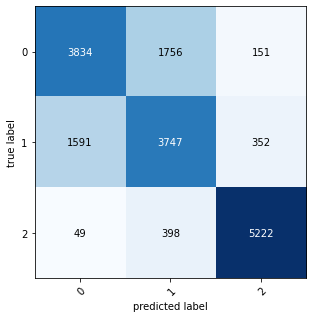

In [174]:
plot_cm(y_valid, y_valid_pred, modelo.classes_)

##### 4.3.2.1 Inferência na base de teste

In [175]:
X_test_transformed = embeddings(X_test, model_w2v)

X_test_transformed.shape

100%|███████████████████████████████████████████████████████████████████████████| 9500/9500 [00:00<00:00, 31123.47it/s]


(9500, 300)

In [176]:
y_test_pred = modelo.predict(X_test_transformed)

print(y_test_pred.shape)

(9500,)


In [177]:
mean_absolute_error(y_test, y_test_pred)

0.2651578947368421

In [178]:
score_test(y_test, y_test_pred)

Teste:
Acc: 0.75, Precision: 0.75, Recall: 0.75


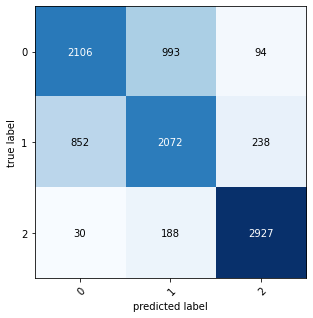

In [179]:
plot_cm(y_test, y_test_pred, modelo.classes_)

##### 4.3.2.2 LightGBM com ajuste manual dos hiperparâmetros

In [180]:
modelo = LGBMClassifier(max_depth=4, random_state=2022)

modelo.fit(X_train_transformed, y_train)

LGBMClassifier(max_depth=4, random_state=2022)

In [181]:
y_train_pred = modelo.predict(X_train_transformed)

y_valid_pred = modelo.predict(X_valid_transformed)

print(y_train_pred.shape, y_valid_pred.shape)

(68400,) (17100,)


In [182]:
score_train(y_train, y_train_pred)

score_valid(y_valid, y_valid_pred)

Treino:
Acc: 0.77, Precision: 0.77, Recall: 0.77
Validação:
Acc: 0.74, Precision: 0.74, Recall: 0.74


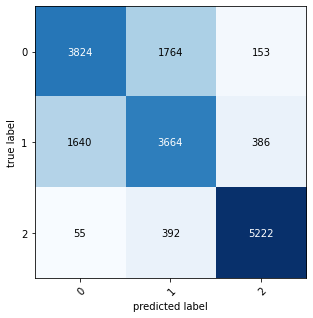

In [183]:
plot_cm(y_valid, y_valid_pred, modelo.classes_)

##### 4.3.2.3 Inferência na base de teste

In [184]:
X_test_transformed = embeddings(X_test, model_w2v)

X_test_transformed.shape

100%|███████████████████████████████████████████████████████████████████████████| 9500/9500 [00:00<00:00, 25190.78it/s]


(9500, 300)

In [185]:
y_test_pred = modelo.predict(X_test_transformed)

print(y_test_pred.shape)

(9500,)


In [186]:
mean_absolute_error(y_test, y_test_pred)

0.27042105263157895

In [187]:
score_test(y_test, y_test_pred)

Teste:
Acc: 0.74, Precision: 0.74, Recall: 0.74


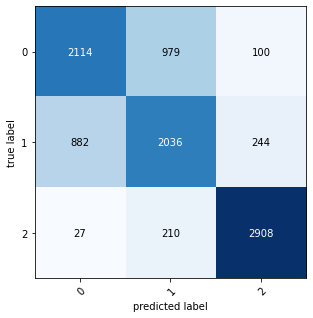

In [188]:
plot_cm(y_test, y_test_pred, modelo.classes_)

#### 4.3.3 Naive Bayes

In [189]:
# Normalizando os dados para rodar o modelo Naive Bayes com Word2Vec
scaler = MinMaxScaler()
X_train_transformed = scaler.fit_transform(X_train_transformed)
X_valid_transformed = scaler.fit_transform(X_valid_transformed)

In [190]:
modelo = MultinomialNB()

modelo.fit(X_train_transformed, y_train)

MultinomialNB()

In [191]:
y_train_pred = modelo.predict(X_train_transformed)

y_valid_pred = modelo.predict(X_valid_transformed)

print(y_train_pred.shape, y_valid_pred.shape)

(68400,) (17100,)


In [192]:
score_train(y_train, y_train_pred)

score_valid(y_valid, y_valid_pred)

Treino:
Acc: 0.64, Precision: 0.63, Recall: 0.64
Validação:
Acc: 0.63, Precision: 0.62, Recall: 0.63


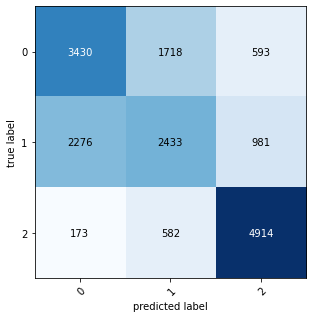

In [193]:
plot_cm(y_valid, y_valid_pred, modelo.classes_)

##### 4.3.3.1 Inferência na base de teste

In [194]:
X_test_transformed = embeddings(X_test, model_w2v)

X_test_transformed.shape

100%|███████████████████████████████████████████████████████████████████████████| 9500/9500 [00:00<00:00, 24002.82it/s]


(9500, 300)

In [195]:
# Normalizando os dados para rodar o modelo Naive Bayes com Word2Vec
scaler = MinMaxScaler()
X_test_transformed = scaler.fit_transform(X_test_transformed)

In [196]:
y_test_pred = modelo.predict(X_test_transformed)

print(y_test_pred.shape)

(9500,)


In [197]:
mean_absolute_error(y_test, y_test_pred)

0.48757894736842106

In [198]:
score_test(y_test, y_test_pred)

Teste:
Acc: 0.59, Precision: 0.59, Recall: 0.59


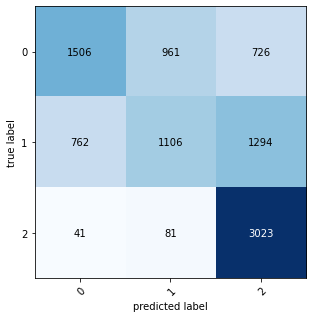

In [199]:
plot_cm(y_test, y_test_pred, modelo.classes_)

## 5. Resultados

- Bag Of Words e Random Forest (max_depth=5):
    
|           | Acurácia | Precisão | Recall | Overfitting | MAE |
|-----------|----------|----------|--------|-------------|-----|
| Treino    |   68%    |   73%    |  68%   |             |     |
| Validação |   68%    |   73%    |  68%   |      0      |     |
| Teste     |   67%    |   73%    |  68%   |             | 34% |


- Bag Of Words e LightGBM:
    
|           | Acurácia | Precisão | Recall | Overfitting | MAE |
|-----------|----------|----------|--------|-------------|-----|
| Treino    |   79%    |   80%    |  79%   |             |     |
| Validação |   77%    |   78%    |  77%   |      2%     |     |
| Teste     |   77%    |   78%    |  77%   |             | 25% |
    
- Bag Of Words e LightGBM (com otimização, utilizando o GridSearch):   
    
|           | Acurácia | Precisão | Recall | Overfitting | MAE |
|-----------|----------|----------|--------|-------------|-----|
| Treino    |   86%    |   87%    |  86%   |             |     |
| Validação |   80%    |   80%    |  80%   |      6%     |     |
| Teste     |   80%    |   80%    |  80%   |             | 21% |

Como houve um overfitting de 6%, fui ajustando os hiperparâmetros até conseguir ao menos 3%.    
    
- Bag Of Words e LightGBM (com ajuste manual dos hiperparâmetros: max_depth=20, n_estimators=300):
    
|           | Acurácia | Precisão | Recall | Overfitting | MAE |
|-----------|----------|----------|--------|-------------|-----|
| Treino    |   82%    |   83%    |  82%   |             |     |
| Validação |   79%    |   79%    |  79%   |      3%     |     |
| Teste     |   78%    |   79%    |  79%   |             | 22% |
    
- Bag Of Words e Naive Bayes:

|           | Acurácia | Precisão | Recall | Overfitting | MAE |
|-----------|----------|----------|--------|-------------|-----|
| Treino    |   82%    |   82%    |  82%   |             |     |
| Validação |   79%    |   79%    |  79%   |      3%     |     |
| Teste     |   79%    |   79%    |  79%   |             | 23% |

- TF-IDF e Random Forest (max_depth=5):

|           | Acurácia | Precisão | Recall | Overfitting | MAE |
|-----------|----------|----------|--------|-------------|-----|
| Treino    |   69%    |   74%    |  69%   |             |     |
| Validação |   68%    |   73%    |  68%   |      1%     |     |
| Teste     |   68%    |   73%    |  68%   |             | 33% |
    
- TF-IDF e e LightGBM:

|           | Acurácia | Precisão | Recall | Overfitting | MAE |
|-----------|----------|----------|--------|-------------|-----|
| Treino    |   80%    |   81%    |  80%   |             |     |
| Validação |   77%    |   79%    |  77%   |      3%     |     |
| Teste     |   77%    |   78%    |  77%   |             | 24% |
       
- TF-IDF e Naive Bayes:
    
|           | Acurácia | Precisão | Recall | Overfitting | MAE |
|-----------|----------|----------|--------|-------------|-----|
| Treino    |   82%    |   82%    |  82%   |             |     |
| Validação |   78%    |   78%    |  78%   |      4%     |     |
| Teste     |   78%    |   78%    |  78%   |             | 23% |

- Word2Vec e Random Forest (max_depth=5):
    
|           | Acurácia | Precisão | Recall | Overfitting | MAE |
|-----------|----------|----------|--------|-------------|-----|
| Treino    |   73%    |   73%    |  73%   |             |     |
| Validação |   71%    |   72%    |  71%   |      2%     |     |
| Teste     |   71%    |   72%    |  72%   |             | 30% |

- Word2Vec e LightGBM:
    
|           | Acurácia | Precisão | Recall | Overfitting | MAE |
|-----------|----------|----------|--------|-------------|-----|
| Treino    |   80%    |   80%    |  80%   |             |     |
| Validação |   75%    |   75%    |  75%   |      5%     |     |
| Teste     |   75%    |   75%    |  75%   |             | 26% |

- Word2Vec e LightGBM (com ajuste manual dos hiperparâmetros: max_depth=4):

|           | Acurácia | Precisão | Recall | Overfitting | MAE |
|-----------|----------|----------|--------|-------------|-----|
| Treino    |   77%    |   77%    |  77%   |             |     |
| Validação |   74%    |   74%    |  74%   |      3%     |     |
| Teste     |   74%    |   74%    |  74%   |             | 27% |
    
- Word2Vec e Naive Bayes:
    
|           | Acurácia | Precisão | Recall | Overfitting | MAE |
|-----------|----------|----------|--------|-------------|-----|
| Treino    |   64%    |   63%    |  64%   |             |     |
| Validação |   63%    |   62%    |  63%   |      1%     |     |
| Teste     |   59%    |   59%    |  59%   |             | 49% |

### 5.1 Escolha do modelo

De acordo com os resultados obtidos, o modelo escolhido foi o Naive Bayes com o Bag Of Words, que obteve um erro absoluto médio de 23% e a melhor acurácia na base de teste (79%), considerando um overfitting de até 3% entre a base de treino e validação.

### 5.2 Executando o modelo escolhido

#### 5.2.1 Bag Of Words

In [200]:
vectorizer = CountVectorizer(max_features=10000)

vectorizer.fit(X_train)
    
X_train_transformed = vectorizer.transform(X_train).toarray()
print(X_train_transformed.shape)

X_valid_transformed = vectorizer.transform(X_valid).toarray()
print(X_valid_transformed.shape)

(68400, 10000)
(17100, 10000)


#### 5.2.2 Naive Bayes

In [201]:
modelo = MultinomialNB()

modelo.fit(X_train_transformed, y_train)

MultinomialNB()

In [202]:
y_train_pred = modelo.predict(X_train_transformed)

y_valid_pred = modelo.predict(X_valid_transformed)

print(y_train_pred.shape, y_valid_pred.shape)

(68400,) (17100,)


In [203]:
score_train(y_train, y_train_pred)

score_valid(y_valid, y_valid_pred)

Treino:
Acc: 0.82, Precision: 0.82, Recall: 0.82
Validação:
Acc: 0.79, Precision: 0.79, Recall: 0.79


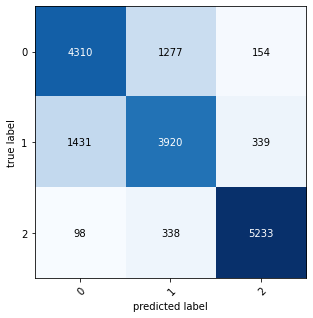

In [204]:
plot_cm(y_valid, y_valid_pred, modelo.classes_)

#### 5.2.3 Inferência na base de teste

In [205]:
X_test_transformed = vectorizer.transform(X_test).toarray()

print(X_test_transformed.shape)

(9500, 10000)


In [206]:
y_test_pred = modelo.predict(X_test_transformed)

print(y_test_pred.shape)

(9500,)


In [207]:
mean_absolute_error(y_test, y_test_pred)

0.22642105263157894

In [208]:
score_test(y_test, y_test_pred)

Teste:
Acc: 0.79, Precision: 0.79, Recall: 0.79


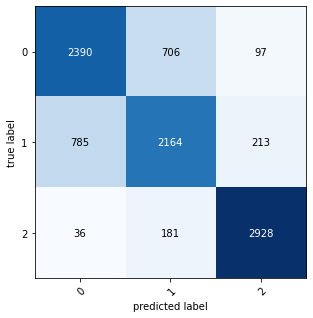

In [209]:
plot_cm(y_test, y_test_pred, modelo.classes_)

In [210]:
# Criando uma coluna ("sentiment_2") com as predições
df_test_2 = df_test.copy()
df_test_2['sentiment_2'] = modelo.predict(X_test_transformed)
df_test_2.head()

,id,tweet_text,tweet_date,sentiment,query_used,sentiment_2
48396,1046719569988071424,"Que semana gostosa ein, sol agora e chuva find :(",Mon Oct 01 11:12:47 +0000 2018,0,:(,0
85465,1043632794012913670,Fim de uma era? Atriz de Grey's Anatomy dá pistas sobre fim da série https://t.co/ghx9PpoGUG,Sat Sep 22 22:47:02 +0000 2018,2,folha,2
82775,1046780017894723584,0 furos :),Mon Oct 01 15:12:59 +0000 2018,1,:),1
11787,1044193740724801537,"Pivô de escândalo sexual envolvendo o Prêmio Nobel, francês deve pegar três anos de prisão https://t.co/oDBgcKzPri",Mon Sep 24 11:56:02 +0000 2018,2,folha,2
71538,1049308609350434816,Minha tia faleceu :(,Mon Oct 08 14:40:42 +0000 2018,0,:(,0


In [211]:
# Verificando o balanceamento dos valores em "sentiment_2"
df_test_2['sentiment_2'].value_counts(normalize=True)*100

2    34.084211
0    33.800000
1    32.115789
Name: sentiment_2, dtype: float64

## 6. Submissão

In [212]:
df_subm = pd.read_csv('Dados/subm/Subm3Classes.csv')

print(df_subm.shape)

df_subm.sample(10).head()

(5000, 4)


,id,tweet_text,tweet_date,query_used
9,1049319300551593989,@LauandaVentura Vou tentar mais uma vez :-),Mon Oct 08 15:23:11 +0000 2018,:)
2094,1049161019048771584,Como foi o melhor sonho que você já teve? — um com o sehyoon kk :( https://t.co/LhovCa9tpg,Mon Oct 08 04:54:14 +0000 2018,:(
615,1048716862933164032,"Em pronunciamento, Rosa Weber defende tolerância e segurança da urna https://t.co/6hmUwrvuGN",Sat Oct 06 23:29:18 +0000 2018,exame
2562,1039247907038347264,"&gt;@EstadaoLink No dia mundial de prevenção ao suicídio, Twitter anuncia novo serviço para alertar usuários https://t.co/yFhb6rOcfj https://t.co/e9R2xEriDV",Mon Sep 10 20:23:03 +0000 2018,estadao
693,1049306823914921984,"@_llolorena eu passei véi, mas agora não consigo nem passar meu piercing mais :(",Mon Oct 08 14:33:36 +0000 2018,:(


In [213]:
X_subm = df_subm['tweet_text']

X_subm = clean_username(X_subm)
X_subm = clean_url(X_subm)
X_subm = normalize_texts(X_subm)
X_subm = clean_pt_stopwords(X_subm)

print(X_subm.shape)

(5000,)


In [214]:
X_subm_transformed = vectorizer.transform(X_subm).toarray()

print(X_subm_transformed.shape)

(5000, 10000)


In [215]:
y_subm_pred = modelo.predict(X_subm_transformed)

print(y_subm_pred.shape)

(5000,)


In [216]:
# Criando uma coluna ("sentiment_predict") com as predições
df_subm_2 = df_subm.copy()
df_subm_2['sentiment_predict'] = modelo.predict(X_subm_transformed)
df_subm_2.head()

,id,tweet_text,tweet_date,query_used,sentiment_predict
0,1046764676707753987,Apartamento Vila Mariana Praça Monteiro dos Santos O iMudou é especialista em imóveis e encontrou 7 oportunidades para a busca apartamento vila mariana praca monteiro dos santos. Temos as ofertas com o menor preço! :) https://t.co/8JlJ0N1Ewe,Mon Oct 01 14:12:01 +0000 2018,:),1
1,1047329264943751169,@FalleNCS @BrasilGameShow quero 1x1 de scout. Dizem que dou muita bala cagada :),Wed Oct 03 03:35:29 +0000 2018,:),1
2,1045443874947313665,mais uma analógica no correio à minha espera :D Só falta receber duas lentes e começar a revelar em casa.,Thu Sep 27 22:43:37 +0000 2018,:),1
3,1040484298711814144,"Em festa de posse como presidente do STF, Toffoli canta Legião Urbana https://t.co/IEs709I35Z",Fri Sep 14 06:16:02 +0000 2018,folha,2
4,1045411876887306240,@thethiagor @jubsilva @GSCISA @GrupoMulheRIs A Flávia tem tuiter também @fmedeirosss :),Thu Sep 27 20:36:28 +0000 2018,:),1


In [217]:
# Verificando o balanceamento dos valores em "sentiment_predict"
df_subm_2['sentiment_predict'].value_counts(normalize=True)*100

2    34.3
0    33.7
1    32.0
Name: sentiment_predict, dtype: float64

In [218]:
# Removendo as colunas desnecessárias para o arquivo csv
df_subm_2 = df_subm_2.drop(['tweet_text', 'tweet_date', 'query_used'], axis=1).copy()
df_subm_2.head()

,id,sentiment_predict
0,1046764676707753987,1
1,1047329264943751169,1
2,1045443874947313665,1
3,1040484298711814144,2
4,1045411876887306240,1


In [219]:
# Salvando o DF em um arquivo csv
df_subm_2.to_csv('projeto_2_nlp.csv', index=False)

In [220]:
# Verificando o arquivo salvo
df_tha = pd.read_csv('projeto_2_nlp.csv')

df_tha.head()

,id,sentiment_predict
0,1046764676707753987,1
1,1047329264943751169,1
2,1045443874947313665,1
3,1040484298711814144,2
4,1045411876887306240,1


## 7. Conclusões

Na primeira etapa do projeto, observou-se a inexistência tanto de dados faltantes quanto de duplicados, no dataframe como um todo.   
Na coluna "tweet_text", havia poucos dados duplicados (menos de 1%) e, portanto, nada foi feito em relação a essas duplicatas.

Na análise exploratória, verificou-se que:   
    - os dados de saída estavam balanceados;   
    - a maioria dos textos duplicados são de sentimento positivo;   
    - os textos maiores tendem a ter um sentimento neutro;   
    - os textos menores tendem a ter um sentimento negativo;   
    - o sentimento negativo nos textos parece estar mais associado à nostalgia ou a um anseio de se obter aquilo que deseja;   
    - os sentimentos negativos e positivos são identificados apenas em um relativo curto período de tempo (época de eleição).

Com os dados preparados, realizou-se o pré-processamento utilizando:   
    - Bag Of Words;   
    - TF-IDF;   
    - Word2Vec.

Com os dados prontos, realizou-se a modelagem utilizando:    
    - Random Forest;      
    - LightGBM;   
    - Naive Bayes.

O modelo escolhido como melhor foi o Naive Bayes, utilizando o Bag Of Words no pré-processamento, por ter apresentado um erro absoluto médio de 23% e a melhor acurácia (79%) na base de teste, considerando um overfitting de até 3% entre a base de treino e validação.